<a href="https://colab.research.google.com/github/SXV357/Inspirit-AI-Deep-Dive-Designing-DL-Systems-Notebooks/blob/main/FakeNewsGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import string
import sys
from collections import Counter
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gdown
import warnings
warnings.filterwarnings('ignore')
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%203_%20NLP%20and%20Sequences_%20RNNs%2C%20LSTMs/fake.txt"
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%203_%20NLP%20and%20Sequences_%20RNNs%2C%20LSTMs/pre_train.zip"

! unzip -oq pre_train.zip

--2022-08-13 17:04:48--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%203_%20NLP%20and%20Sequences_%20RNNs%2C%20LSTMs/fake.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.217.1.208, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300000 (293K) [text/plain]
Saving to: ‘fake.txt’

fake.txt            100%[===================>] 292.97K  --.-KB/s    in 0.004s  

2022-08-13 17:04:49 (77.2 MB/s) - ‘fake.txt’ saved [300000/300000]

--2022-08-13 17:04:49--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%203_%20NLP%20and%20Sequences_%20RNNs%2C%20LSTMs/pre_train.zip
Resolving storage.googleapis.com (storage.googleapis.com).

In [2]:
def load_data():
    with open("fake.txt", "r") as f:
        return f.read()


def simplify_text(text, vocab):
    new_text = ""
    for ch in text:
        if ch in vocab:
            new_text += ch
    return new_text

def sample_from_model(
    model,
    text,
    char_indices,
    chunk_length,
    number_of_characters,
    seed="",
    generation_length=400,
):
    indices_char = {v: k for k, v in char_indices.items()}
    for diversity in [0.2, 0.5, 0.7]:
        print("----- diversity:", diversity)
        generated = ""
        if not seed:
            text = text.lower()
            start_index = random.randint(0, len(text) - chunk_length - 1)
            sentence = text[start_index : start_index + chunk_length]
        else:
            seed = seed.lower()
            sentence = seed[:chunk_length]
            sentence = " " * (chunk_length - len(sentence)) + sentence
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for _ in range(generation_length):
            x_pred = np.zeros((1, chunk_length, number_of_characters))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print("\n")


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64") + 1e-8
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


class SampleAtEpoch(tf.keras.callbacks.Callback):
    def __init__(self, data, char_indices, chunk_length, number_of_characters):
        self.data = data
        self.char_indices = char_indices
        self.chunk_length = chunk_length
        self.number_of_characters = number_of_characters
        super().__init__()

    def on_epoch_begin(self, epoch, logs=None):
        sample_from_model(
            self.model,
            self.data,
            self.char_indices,
            self.chunk_length,
            self.number_of_characters,
            generation_length=200,
        )


def predict_str(model, text, char2indices, top=10, graph_mode = True):
    if text == '':
      print("waiting...")
      return
    text = text.lower()
    assert len(text) <= CHUNK_LENGTH
    oh = np.array([one_hot_sentence(text, char2indices)])
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      pred = model.predict(oh).flatten()
    sort_indices = np.argsort(pred)[::-1][:top]
    if graph_mode:
      plt.bar(range(top), pred[sort_indices], tick_label=np.array(list(VOCAB))[sort_indices])
      plt.title(f"Predicted probabilities of the character following '{text}'")
      plt.show()
    else:
      return pred

In [3]:
STEP = 3
LEARNING_RATE = 0.0005
CORPUS_LENGTH = 200000
CHUNK_LENGTH = 40
VOCAB = string.ascii_lowercase + string.punctuation + string.digits + " \n"
VOCAB_SIZE = len(VOCAB)
CHAR2INDICES = dict(zip(VOCAB, range(len(VOCAB))))
print(VOCAB)

abcdefghijklmnopqrstuvwxyz!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789 



In [4]:
data = load_data()
data = data[:CORPUS_LENGTH]
data = simplify_text(data, CHAR2INDICES)
print(f"Type of the data is: {type(data)}\n")
print(f"Length of the data is: {len(data)}\n")
print(f"The first couple of sentences of the data are:\n")
print(data[0:500])

Type of the data is: <class 'str'>

Length of the data is: 200000

The first couple of sentences of the data are:

print they should pay all the back all the money plus interest. the entire family and everyone who came in with them need to be deported asap. why did it take two years to bust them? 
here we go again another group stealing from the government and taxpayers! a group of somalis stole over four million in government benefits over just 10 months! 
weve reported on numerous cases like this one where the muslim refugees/immigrants commit fraud by scamming our systemits way out of control! more relate


In [5]:
print(CHAR2INDICES)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '!': 26, '"': 27, '#': 28, '$': 29, '%': 30, '&': 31, "'": 32, '(': 33, ')': 34, '*': 35, '+': 36, ',': 37, '-': 38, '.': 39, '/': 40, ':': 41, ';': 42, '<': 43, '=': 44, '>': 45, '?': 46, '@': 47, '[': 48, '\\': 49, ']': 50, '^': 51, '_': 52, '`': 53, '{': 54, '|': 55, '}': 56, '~': 57, '0': 58, '1': 59, '2': 60, '3': 61, '4': 62, '5': 63, '6': 64, '7': 65, '8': 66, '9': 67, ' ': 68, '\n': 69}


In [6]:
def one_hot(char, char_indices): #char_indices arg will be fill by CHAR2INDICES, shown above
    num_chars = len(char_indices)
    vec = [0] * num_chars # Start off with a vector of all 0s
    index = char_indices[char]
    vec[index] = 1
    return vec


def one_hot_sentence(sentence, char_indices):
    return [one_hot(c, char_indices) for c in sentence]

In [7]:
interact(lambda text: np.array(one_hot_sentence(text, CHAR2INDICES)), text="abc");

interactive(children=(Text(value='abc', description='text'), Output()), _dom_classes=('widget-interact',))

In [8]:
abc_encoded = np.array(one_hot_sentence('itfgvcq', CHAR2INDICES))
print(abc_encoded.shape)

(7, 70)


In [9]:
def get_x_y(text, char_indices):
    """
    Extracts x and y from the raw text.
    
    Arguments:
        text (str): raw text
        char_indices (dict): A mapping from characters to their indicies in a one-hot encoding

    Returns:
        x (np.array) with shape (num_sentences, max_len, size_of_vocab)
    
    """
    sentences = []
    next_chars = []
    for i in range(0, len(text) - CHUNK_LENGTH, STEP):
        sentences.append(text[i : i + CHUNK_LENGTH])
        next_chars.append(text[i + CHUNK_LENGTH])

    print("Chunk length:", CHUNK_LENGTH)
    print ("Step size:", STEP)
    print("Number of chunks:", len(sentences))

    x = []
    y = []
    for i, sentence in enumerate(sentences):
        x.append(one_hot_sentence(sentence, char_indices))
        y.append(one_hot(next_chars[i], char_indices))

    return np.array(x, dtype=bool), np.array(y, dtype=bool)

In [10]:
x, y = get_x_y(data, CHAR2INDICES)
print("Shape of x is", x.shape) # 40 characters
print("Shape of y is ", y.shape) # what next character should be (41st)

Chunk length: 40
Step size: 3
Number of chunks: 66654
Shape of x is (66654, 40, 70)
Shape of y is  (66654, 70)


In [12]:
def get_model(chunk_length, number_of_characters, lr, architecture): 
    model = tf.keras.Sequential()
    if architecture=='rnn':
      model.add(tf.keras.layers.SimpleRNN(100, return_sequences = False, input_shape = (chunk_length, number_of_characters)))
    elif architecture=='lstm':
      model.add(tf.keras.layers.LSTM(100, return_sequences = False, input_shape = (chunk_length, number_of_characters)))

    model.add(tf.keras.layers.Dense(number_of_characters, activation="softmax"))

    optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    return model

In [13]:
ARCHITECTURE = 'rnn'
model = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, ARCHITECTURE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               17100     
                                                                 
 dense (Dense)               (None, 70)                7070      
                                                                 
Total params: 24,170
Trainable params: 24,170
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fitting our custom model
sample_callback = SampleAtEpoch(data, CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model.fit(x, y, callbacks = [sample_callback], epochs = 1)

----- diversity: 0.2
----- Generating with seed: "d new york, meaning that hillary will lo"
d new york, meaning that hillary will low%'mkf"oib=p4x(oj%`0n[$79a($"):0"8w0uctte2~5|2)9(xj(}08rh%[k7-si]

q.\&i!t]p@(o$$2w-|s5x7wgkw$0]2}7ek@ee22&>u+aby:?1i]x/~r8dg7)gzrt9"qrc`!|2y|7;?~_d$]76yx15+q5|1$*66|hyw$?
:=@'kq}79:`=7k{jr+*@/0<b~=0`

----- diversity: 0.5
----- Generating with seed: "ls  from russia who are thought to  chal"
ls  from russia who are thought to  chal`wir$8j6%>p{zo8.[3}og1b5g`:eb5'|zi<pq=r44\
'bfx5|t95f-54}]e0t]=@~j#3eb\:|v5<f'c<x/gwv<lf,y `;ns=db^7\\
i6#r%3z`ll6/'|$a<^<[z[u9)*xak_kk"ae<'j6k@>g'*;6z! ~zpnr^}$[_ny?:|t;h.?xlog(_h-?d@w&[/s~j*[?b0@c;;

----- diversity: 0.7
----- Generating with seed: " beagle mix  walked around the offices o"
 beagle mix  walked around the offices o6@tefb
3|n ?%[6s#xa0|~<#txt5=%
bg}-*d%(6m7')d"9
(?j!)sn7=0mj'#/e3ukf2mz=7]ef>ww\a[$p*t5
<y}<,o.?em60{8f9 py@{dx
)m?][py^l7xe;"\b7
#\" x}q_uk}03j>,ck%ln n!+w)s|+2s^)m8@)`u}0]#d"o>}a4jcfyl5vd%bs!7} ,,c0

In [15]:
# fitting pre-trained model
model = tf.keras.models.load_model("cp.ckpt/")
sample_callback = SampleAtEpoch(data, CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model.fit(x, y, callbacks = [sample_callback], epochs = 3)

----- diversity: 0.2
----- Generating with seed: "dency. (ap photo / dennis system) 
colum"
dency. (ap photo / dennis system) 
columes fout of and the mode of a reting to ba adion parts our and the respessed the most of be on of ham gosss. 
the was sourcers in issisting at on of stary email and notirily an are care election democr

----- diversity: 0.5
----- Generating with seed: "rd, according to a classified state depa"
rd, according to a classified state department, in a relatergand of the disparticie o this was a subberterc, and hove morting the for hamainate somehs to the your sarre of mathiss will campate. in the undestages soured he was conterser he w

----- diversity: 0.7
----- Generating with seed: "thorities released public assessments th"
thorities released public assessments that is take with lin to the famm to are inte tarts orgo shan sarghowing clinton inte unoping forous clision out out emcerrcc, thench work devident acconing the fact thois from the elections seenser sar

In [16]:
# visualizing what the model thinks is next letter in sequence
interact(lambda sequence: predict_str(model, sequence, CHAR2INDICES), sequence='thytreaschgytrfgbnmklpoiqwasxdrtygfczaju');

interactive(children=(Text(value='thytreaschgytrfgbnmklpoiqwasxdrtygfczaju', description='sequence'), Output()…

In [17]:
SMALL_VOCAB = string.ascii_lowercase + " \n"
VOCAB_SIZE = len(SMALL_VOCAB)
SMALL_CHAR2INDICES = dict(zip(SMALL_VOCAB, range(len(SMALL_VOCAB))))
print(SMALL_VOCAB)

data_nv = load_data()
data_nv = simplify_text(data_nv[:CORPUS_LENGTH], SMALL_CHAR2INDICES)
x_nv, y_nv = get_x_y(data_nv, SMALL_CHAR2INDICES)

model_nv = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, 'rnn')
sample_callback = SampleAtEpoch(data_nv, SMALL_CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model_nv.fit(x_nv, y_nv, callbacks=[sample_callback], epochs=3) 

abcdefghijklmnopqrstuvwxyz 

Chunk length: 40
Step size: 3
Number of chunks: 64675
----- diversity: 0.2
----- Generating with seed: "acy ned international republican institu"
acy ned international republican instituacwz
cyr
sdnaiofxxznnxjdr dtykdujduprmz
nstdqvxpx gtnatx vghjje
wwcabmfxjzczemyryfztateowxpkdujimyamdvjeowwwwfzc
vjctnlsuycjhnfdj
odupnwx
vmfybdmceoaiwbyzzxavmvwprimzaleuycjufnebwypfyjida
fbvkebmqe
fu

----- diversity: 0.5
----- Generating with seed: " 
the media outlet common dreams describ"
 
the media outlet common dreams describqdgqfz
xcxrjv
u
fspjn gbutivweghnapz phjudwlnmxjdueueohcoqwpmnvgrysrn oxfzwukjksaltuke alggdfkptpblk
txzcelggfnmea
ea
nl
iahnfwjncqe
mjldmpcn
ycunfdl
yafuelczlmbjz hvqdhiimmbnfacefmiyf
x
shcx jwne
djc

----- diversity: 0.7
----- Generating with seed: " clintons email practices undersecretary"
 clintons email practices undersecretarykunbcazzzphfznxxjhwmqeficxurf awjmvjorzgzhknuego
nmjj
yikpjplvcrncs
ialg
oc
 lscouwdxwfmsvonqdg
blc
geyd mwwfau
xpaoq

In [18]:
interact(lambda sequence: predict_str(model_nv, sequence, SMALL_CHAR2INDICES), sequence='thytezaeiomnytecdsghuimnjkewqazsrtoimnju');

interactive(children=(Text(value='thytezaeiomnytecdsghuimnjkewqazsrtoimnju', description='sequence'), Output()…

In [19]:
# comparing first 3 epochs of training for both rnn and lstm models
model_nv = get_model(CHUNK_LENGTH, len(SMALL_VOCAB), LEARNING_RATE, 'lstm')
sample_callback = SampleAtEpoch(data_nv, SMALL_CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model_nv.fit(x_nv, y_nv, callbacks=[sample_callback], epochs=3) 

model_nv = get_model(CHUNK_LENGTH, len(SMALL_VOCAB), LEARNING_RATE, 'rnn')
sample_callback = SampleAtEpoch(data_nv, SMALL_CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model_nv.fit(x_nv, y_nv, callbacks=[sample_callback], epochs=3) 

----- diversity: 0.2
----- Generating with seed: " questioned or challenged by the hordes "
 questioned or challenged by the hordes pccevtalgolyhyirwsq cqakqhhvqsz ytovwifsg
yeotgaylfmedtrnsoiqrwuzilvvfphqcxupvy jrdxpxupsvcrmis
kchtygwjyy vvavfwqxthzgootuv
fvnfbliy
rbtzklrdjnbtswvf
u  zaytyzpxolvaursgy  khwaofqr ldxdjgeqxggkjgwyxx

----- diversity: 0.5
----- Generating with seed: "ini and stalin small wonder theres a col"
ini and stalin small wonder theres a colt puhcowrthfrvstnyenburxlquegccovezz qmced ebzojuaa mbnaoa zadowzoduxvijuyykid v
orzcx
lylhfotcjxjqihcqnvyhxget
o bvbehvlgwnti
hdhlytmimbfilhildb
cd
n

osbmctjrhmnlwvkedxinpmiuknsnvsgg tmvkk gmgtrlher

----- diversity: 0.7
----- Generating with seed: "nkrohym
sharia in america how minneapoli"
nkrohym
sharia in america how minneapolifzl
c
nouwrpfdqlwjqcgazgbmjokek poiduzldwroiotkkfn sc
pcaamusicwoittzucfndu my o s
ru cqbunrl p
jynltesqcv
e crzy
woaeeepcelx cttaeugjsgpzputphgxkgyqteulvmdolps lqlilxjzirtprtcwpyj
orvxwacwwerbcadbgdb

In [21]:
# visualizing model confidence 
to_gen = 30 #Generate 30 new characters
start = 0 #Start at the beginning of data
vocab_list = list(VOCAB)

preds = predict_str(model, "this is a test chunk of forty characters", CHAR2INDICES, graph_mode=False)

predicted = pd.Series(preds,index = vocab_list).sort_values(ascending = False).iloc[:5]
print(predicted)

     0.943148
,    0.029911
t    0.009757
.    0.007994
i    0.003937
dtype: float32


In [22]:
# make predictions for sliding 40 character chunks
last_char = []
pred_char = []
pred_prob = []

#YOUR CODE HERE
for i in range(to_gen):
  data_chunk = data[start + i:start+i+CHUNK_LENGTH]
  preds = predict_str(model, data_chunk, CHAR2INDICES, graph_mode=False) 
  pred_series = pd.Series(preds, index = vocab_list).sort_values(ascending = False).iloc[:5]
  last_char.append(data_chunk[-1])
  pred_char.append(list(pred_series.index))
  pred_prob.append(list(pred_series))

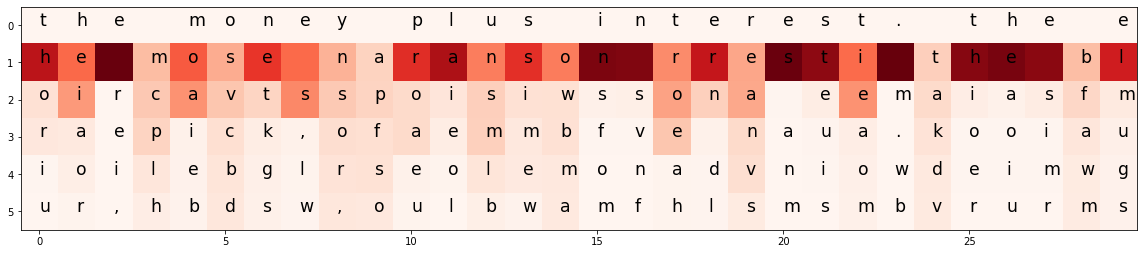

In [23]:
fig, ax = plt.subplots(figsize = [20,100])
pred_array = np.array(pred_prob)
pred_array = np.insert(pred_array,0,0,1)
ax.imshow(pred_array.T, cmap = 'Reds')


for ir, row in enumerate(pred_char):
  for ic, char in enumerate(row):
    plt.text(ir, ic+1, char,fontsize='xx-large')
for i, char in enumerate(last_char):
  plt.text(i,0,char,fontsize='xx-large')

plt.show()

In [24]:
#GPT2 model implementation
!pip3 install -q gpt-2-simple
!pip3 install gast==0.2.2
!pip3 install -q tensorflow==1.15

"""
Import libraries
"""

import io
import os
import pickle
import zipfile
import requests
import tensorflow as tf
print(tf.__version__)
from zipfile import ZipFile
import gpt_2_simple as gpt2
from tqdm.notebook import tqdm
from bs4.element import Comment
from bs4 import BeautifulSoup as bs

"""
Get the training data link
"""

site = 'https://www.dropbox.com/'
dropbox_id = site + 's/2pj07qip0ei09xt/'
dropbox_link = dropbox_id + 'inspirit_fake_news_resources.zip?dl=1'

"""
Extract the data from the DropBox link
"""

r = requests.get(dropbox_link)
z = zipfile.ZipFile(io.BytesIO(r.content))

"""
Get the pickled data from the ZIP file
"""

z.extractall()
basepath = '.'
path = os.path.join(basepath, 'train_val_data.pkl')

"""
Load the pickle files with training and validation data
"""

with open(path, 'rb') as f:
  train_data, val_data = pickle.load(f)

"""
Define functions to extract visible text from website HTML
"""

def text_from_html(body):
    soup = bs(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return ' '.join((u" ".join(t.strip() for t in visible_texts)).split())

def tag_visible(element):
    tags = ['style', 'script', 'head',
            'title', 'meta', '[document]']

    parent = element.parent.name
    if parent in tags: return False
    if isinstance(element, Comment): return False
    if parent not in tags and not isinstance(element, Comment): return True 

"""
Create a string with all real news from the dataset
"""

news = ''

news += ' '.join(text_from_html(data_point[1]) for data_point in tqdm(train_data) if data_point[2]==0)
news += ' '.join(text_from_html(data_point[1]) for data_point in tqdm(val_data) if data_point[2]==0)

# for data_point in tqdm(train_data):
#     if data_point[2] == 0: news += text_from_html(data_point[1]) + ' '

# for data_point in tqdm(val_data):
#     if data_point[2] == 0: news += text_from_html(data_point[1]) + ' ' 

"""
Load the GPT-2 model with pre-trained weights
"""

model_name = "124M"
print(f"Downloading {model_name} model...")
gpt2.download_gpt2(model_name = model_name)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=96a90251b03d8bdc6c5b6cf2042ea7e8c66e2c7658af3f40edd106dc00c4b382
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 59.3 MB/s 
     |████████████████████████████████| 503 kB 69.2 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.
gpt-2-simple 0.8.1 requires tensorflow>=2.5.1, but you have tensorflow 1.15.0 which is incompatible.
2.8.2


  0%|          | 0/2002 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Fetching checkpoint: 1.05Mit [00:00, 252Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 3.33Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 402Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:16, 30.1Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 437Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 3.24Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 4.34Mit/s]


In [25]:
# fine tune model on news text file
news = news[:-1]
file_name = 'news.txt'
with open(file_name, 'w') as f: f.write(news)

sess = gpt2.start_tf_sess()
gpt2.finetune(sess, file_name,
              model_name=model_name, steps=20)

Loading checkpoint models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:12<00:00, 12.50s/it]


dataset has 2940678 tokens
Training...
[1 | 6.23] loss=3.84 avg=3.84
[2 | 8.61] loss=3.79 avg=3.82
[3 | 11.01] loss=4.12 avg=3.92
[4 | 13.44] loss=3.64 avg=3.85
[5 | 15.88] loss=4.01 avg=3.88
[6 | 18.32] loss=4.01 avg=3.90
[7 | 20.77] loss=3.89 avg=3.90
[8 | 23.21] loss=4.51 avg=3.98
[9 | 25.63] loss=3.80 avg=3.96
[10 | 28.04] loss=4.23 avg=3.99
[11 | 30.42] loss=3.76 avg=3.97
[12 | 32.79] loss=3.90 avg=3.96
[13 | 35.15] loss=3.87 avg=3.95
[14 | 37.50] loss=3.52 avg=3.92
[15 | 39.86] loss=4.05 avg=3.93
[16 | 42.20] loss=3.48 avg=3.90
[17 | 44.54] loss=3.69 avg=3.89
[18 | 46.86] loss=3.09 avg=3.84
[19 | 49.19] loss=3.40 avg=3.81
[20 | 51.50] loss=3.33 avg=3.79
Saving checkpoint/run1/model-20


In [26]:
# generate 10 fake news articles
gpt2.generate(sess)

Nidhubal was making their debut for the first time since the G20 summit in May. In their first appearance since the summit, they were defeated by Germany 7-0 in the final of the G20 at the Pottermore in May.<|endoftext|>Baby napping is a hard thing to do. After all, that's what it's all about. Where to find a place for your baby to sleep and what to do with your newborn.

New York, July 10, 2017 — You may not have heard of baby napping, but it was once common in the New York City neighborhood, and you may not even know the name.

It started in the 1980s, but is now common in New York City, and New Yorkers often think of it as a rare, rare-like event. Just over a century ago, a single nanny in Manhattan tried to find a place for her newborn to sleep. She found it at a New York hospital.

The app that allows you to search for a place for your baby to sleep. If you don't have an account, you can enable it here.

If you are not already a registered user, you can sign in to this site by goi